/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.0394
Epoch [2/10], Loss: 0.0116
Epoch [3/10], Loss: 0.1421
Epoch [4/10], Loss: 0.0124
Epoch [5/10], Loss: 0.0290
Epoch [6/10], Loss: 0.0139
Epoch [7/10], Loss: 0.0722
Epoch [8/10], Loss: 0.0698
Epoch [9/10], Loss: 0.0600
Epoch [10/10], Loss: 0.0189
Average PSNR on Test Images: 0.03 dB
Average PSNR on Test Images: 0.04 dB
Average PSNR on Test Images: 0.05 dB
Average PSNR on Test Images: 0.05 dB
Average PSNR on Test Images: 0.06 dB
Average PSNR on Test Images: 0.07 dB
Average PSNR on Test Images: 0.08 dB
Average PSNR on Test Images: 0.09 dB


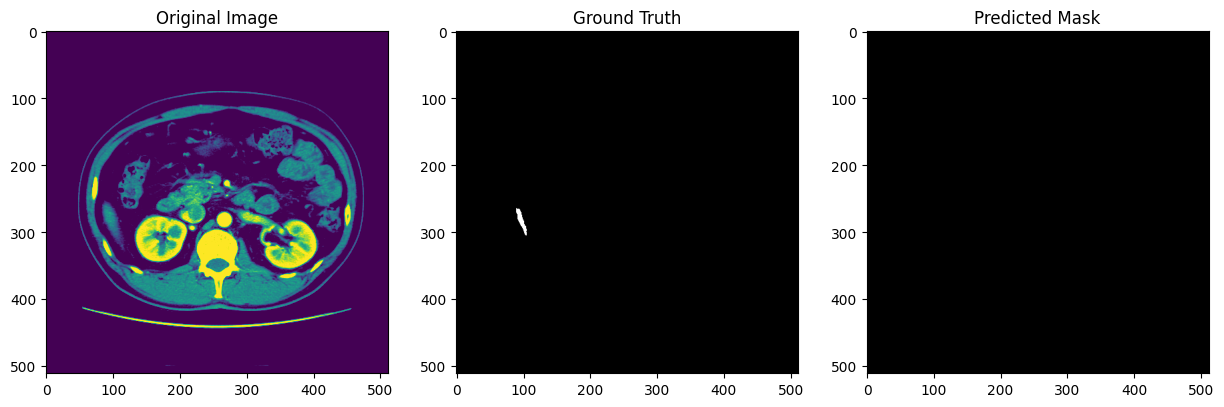

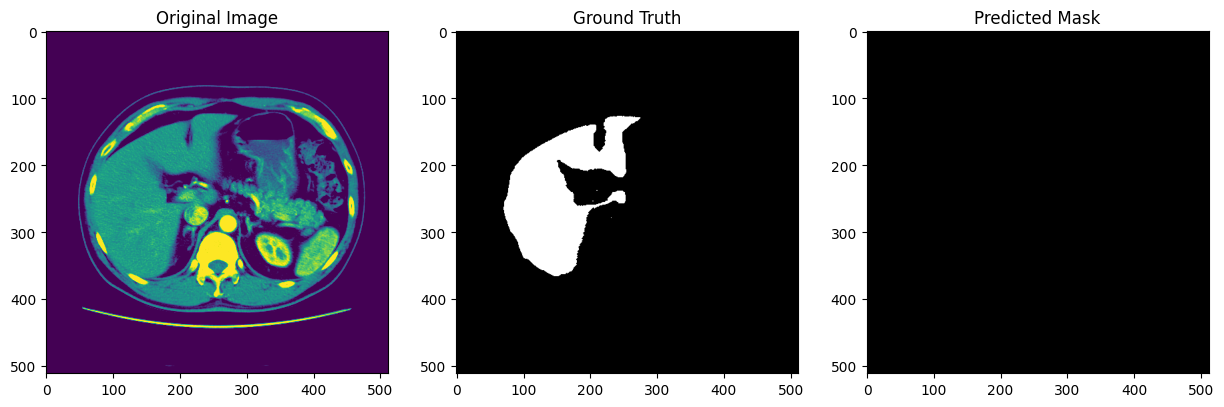

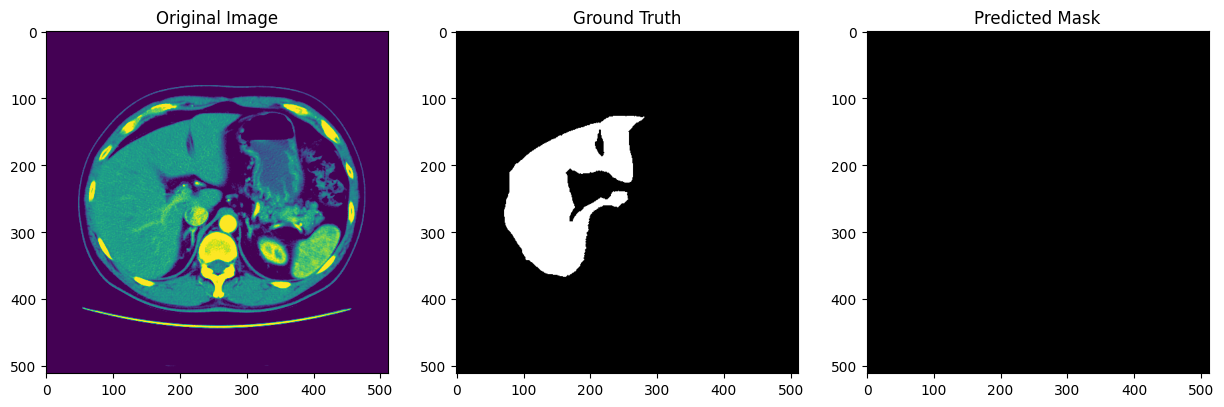

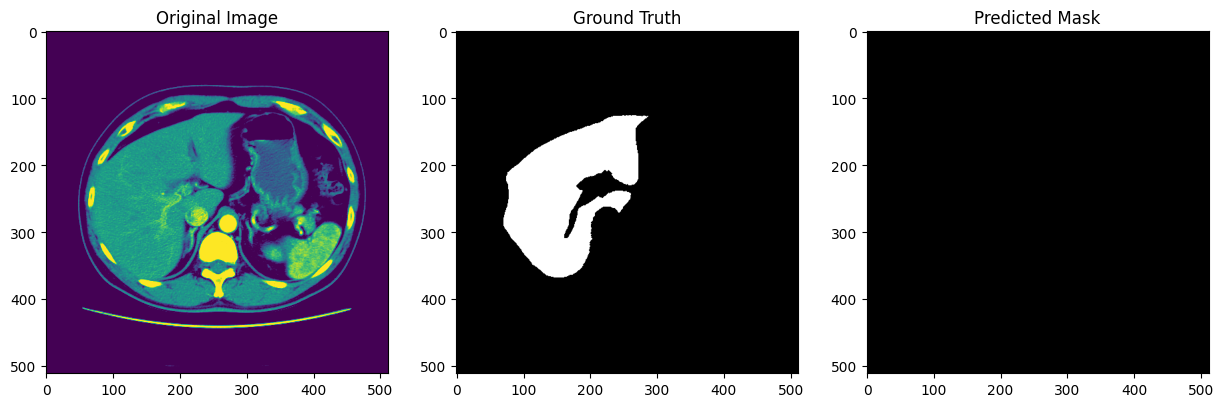

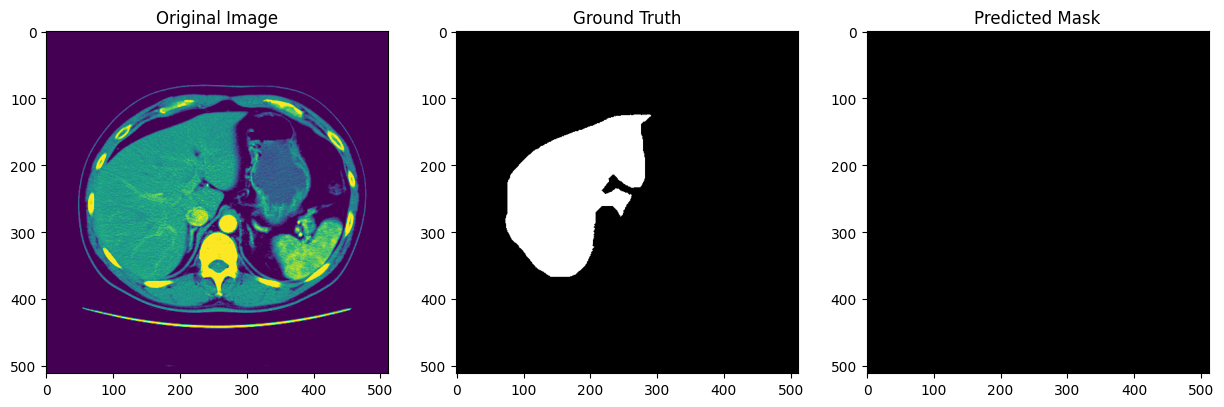

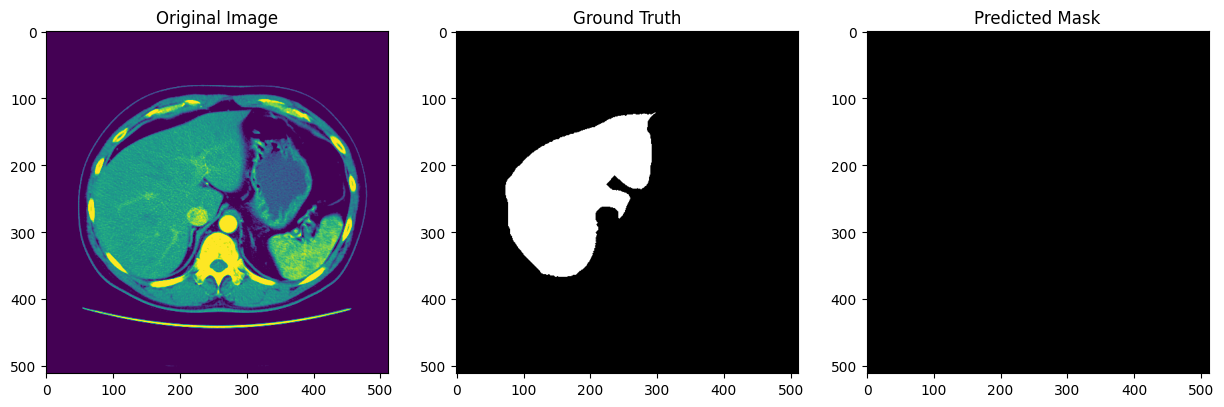

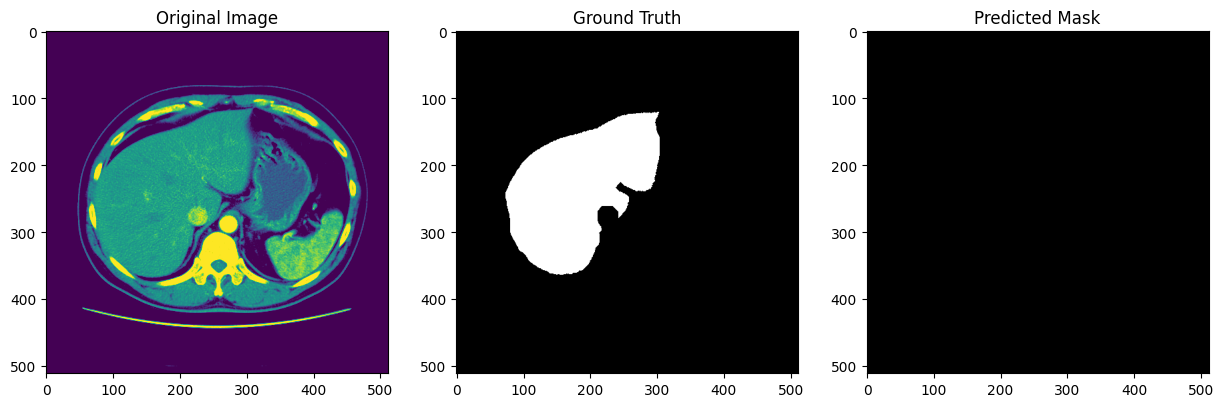

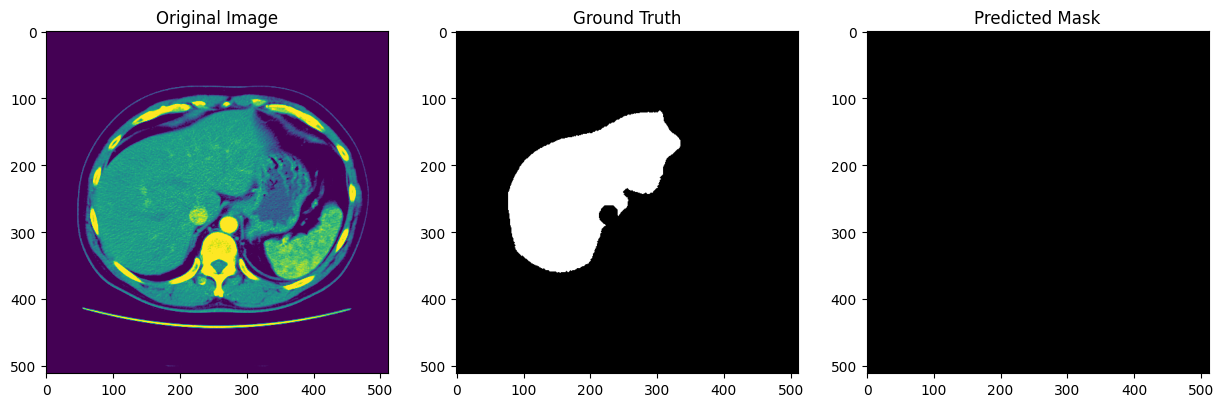

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np

# UNetの定義
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # 畳み込みブロック（Conv2d + ReLUを2回）
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # エンコーダ部
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.MaxPool2d(kernel_size=2, stride=2)(e1))
        e3 = self.encoder3(nn.MaxPool2d(kernel_size=2, stride=2)(e2))
        e4 = self.encoder4(nn.MaxPool2d(kernel_size=2, stride=2)(e3))

        # ボトルネック部
        b = self.bottleneck(nn.MaxPool2d(kernel_size=2, stride=2)(e4))

        # デコーダ部
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))

        # 出力層
        return self.final_conv(d1)

# データセットの定義
class CTScanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')

      if self.transform:
          image = self.transform(image)
          mask = self.transform(mask)

      if mask.ndim == 2:
            mask = mask.unsqueeze(0)

      return image, mask

# PSNRの計算関数
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


# ハイパーパラメータの設定
num_epochs = 10
learning_rate = 1e-4

# トランスフォームの定義
transform = transforms.Compose([
    transforms.ToTensor(),
])

# データセットのインスタンス化
train_dataset = CTScanDataset("/content/drive/MyDrive/Train_Data/ART-IMG", "/content/drive/MyDrive/Train_Data/ART-MASK", transform=transform)
test_dataset = CTScanDataset("/content/drive/MyDrive/Test_Data/ART-IMG", "/content/drive/MyDrive/Test_Data/ART-MASK", transform=transform)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# モデルのインスタンス化と損失関数、オプティマイザの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()  # セグメンテーションのための損失関数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 学習ループ
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        imgs, masks = data
        imgs = imgs.to(device)
        masks = masks.to(device)

        # 順伝播
        outputs = model(imgs)
        loss = criterion(outputs, masks.float())

        # 逆伝播と最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# モデルの評価
model.eval()
total_psnr = 0
with torch.no_grad():


    for data in test_loader:
        imgs, masks = data
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)

        # PSNRの計算
        for i in range(len(imgs)):
            output_img = outputs[i].cpu().numpy().squeeze() * 255
            mask_img = masks[i].cpu().numpy().squeeze() * 255
            psnr = calculate_psnr(output_img, mask_img)
            total_psnr += psnr
            avg_psnr = total_psnr / len(test_loader.dataset)
            print(f'Average PSNR on Test Images: {avg_psnr:.2f} dB')

        # 結果を表示
        for i in range(len(imgs)):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            axes[0].set_title('Original Image')
            axes[1].imshow(masks[i].cpu().squeeze(), cmap='gray')
            axes[1].set_title('Ground Truth')
            axes[2].imshow(outputs[i].cpu().squeeze(), cmap='gray')
            axes[2].set_title('Predicted Mask')
            plt.show()
        break

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np

# UNetの定義
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # 畳み込みブロック（Conv2d + ReLUを2回）
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # エンコーダ部
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.MaxPool2d(kernel_size=2, stride=2)(e1))
        e3 = self.encoder3(nn.MaxPool2d(kernel_size=2, stride=2)(e2))
        e4 = self.encoder4(nn.MaxPool2d(kernel_size=2, stride=2)(e3))

        # ボトルネック部
        b = self.bottleneck(nn.MaxPool2d(kernel_size=2, stride=2)(e4))

        # デコーダ部
        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))

        # 出力層
        return self.final_conv(d1)

# データセットの定義
class CTScanDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])
      image = Image.open(image_path)
      mask = Image.open(mask_path)

      if self.transform:
          image = self.transform(image)
          mask = self.transform(mask)

      if mask.ndim == 2:
            mask = mask.unsqueeze(0)

      return image, mask

# PSNRの計算関数
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


# ハイパーパラメータの設定
num_epochs = 10
learning_rate = 1e-4

# トランスフォームの定義
transform = transforms.Compose([
    transforms.ToTensor(),
])

# データセットのインスタンス化
train_dataset = CTScanDataset("/content/drive/MyDrive/Train_Data/ART-IMG", "/content/drive/MyDrive/Train_Data/ART-MASK", transform=transform)
test_dataset = CTScanDataset("/content/drive/MyDrive/Test_Data/ART-IMG", "/content/drive/MyDrive/Test_Data/ART-MASK", transform=transform)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# モデルのインスタンス化と損失関数、オプティマイザの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()  # セグメンテーションのための損失関数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 学習ループ
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        imgs, masks = data
        imgs = imgs.to(device)

        # 順伝播
        outputs = model(imgs)
        loss = criterion(outputs, masks.float())

        # 逆伝播と最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# モデルの評価
model.eval()
total_psnr = 0
with torch.no_grad():

    for data in test_loader:
        imgs, masks = data
        imgs = imgs.to(device)
        outputs = model(imgs)
        outputs = torch.sigmoid(outputs)

        # PSNRの計算
        for i in range(len(imgs)):
            output_img = outputs[i].cpu().numpy().squeeze() * 255
            mask_img = masks[i].cpu().numpy().squeeze() * 255
            psnr = calculate_psnr(output_img, mask_img)
            total_psnr += psnr
            avg_psnr = total_psnr / len(test_loader.dataset)
            print(f'Average PSNR on Test Images: {avg_psnr:.2f} dB')

        # 結果を表示
        for i in range(len(imgs)):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            axes[0].set_title('Original Image')
            axes[1].imshow(masks[i].cpu().squeeze())
            axes[1].set_title('Ground Truth')
            axes[2].imshow(outputs[i].cpu().squeeze())
            axes[2].set_title('Predicted Mask')
            plt.show()
        break